Se le brinda la implementación en C del producto matriz-vector para el caso en que los datos están ordenados en memoria por filas (Column-Major). 

Pregunta 1 (7 puntos) 

Pregunta 2 (6 puntos) 

*   Implementar los casos presentados en C en Python.
*   Medir el error relativo de las implementación para comprobar la precisión  a un tamaño de matriz de 1024. Como referencia emplee la operación `dot` proporcionada por el módulo `numpy`.

Pregunta 3 (7 puntos)

* Implementar los casos presentados en C en ensamblador x64. Realizar el análisis temporal para los siguientes valores de N = [ 256, 512, 1024, 2048, 4096]. Reportar una gráfica de N vs tiempo [ms] por cada tipo de arreglo en dónde figuren los resultados del tiempo de ejecución representativo de los 3 algoritmos.
IMPORTANTE: Considerar que para el cálculo del tiempo de ejecución representativo debe tomar la mediana, media armónica o promedio (después del filtro mediano). El número de iteraciones se deja a criterio del alumno.

* Asumir la función más lenta como referencia y calcular el SpeedUP por función para cada N escogido en el item anterior.

Comentarios:

* La pregunta 1 se resuelve durante el laboratorio.
* La pregunta 2 se resuelve durante el laboratorio.
* La pregunta 3 se resuelve de manera asíncrona y se presenta el domingo hasta las 22:00.

RODRIGO URQUIZO 20193339

*   CMRV:Column Major Row View
*   CMCV:Column Major Column View

## Dependencias

In [1]:
import numpy as np
import time
from statistics import mean, median
import ctypes
import matplotlib.pyplot as plt

In [2]:
def filtro_mediana(sign, w):
    signc = []
    lc = sign+sign+sign
    ii = len(sign)
    for i in range(len(sign)):
        izq = i + ii - w//2
        der = i + ii + w//2
        signc.append(median(lc[izq:der+1]))
    return signc

Los datos de memoria caché son los siguientes:

In [ ]:
! lscpu | grep "cache"

L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K


In [ ]:
!sudo apt install nasm

## Column-Major Row-View

In [4]:
%%file matvecCMRV_asm.asm
global matvecCMRV_asm
section .text

;RDI<-A[0]  RSI<-x[0]  RDX<-b[0] RCX<-N

matvecCMRV_asm:
xorpd xmm0,xmm0             ;tmp
xorpd xmm1,xmm1
xorpd xmm2,xmm2
mov r8, 0                   ;i=0
mov r9, 0                   ;j=0
mov r10, rcx                ;r10=N
mov r11, rdi                ;r11=A[0] 

buclej:
mov rax, r9                 ;rax<-j
mul r10b                    ;rax<-j*N
add rax, r8                 ;rax<- j*N + i
movsd xmm1, [rdi + 8*rax] 	;A[i + j*N]
movsd xmm2, [rsi + 8*r9] 	;x[j] 
mulsd xmm1, xmm2 			;xmm1<-A[i + j*N]*x[j]
addsd xmm0, xmm1  			;tmp += xmm1
cmp r9, rcx
je inc_i                    ;si j=N sale del bucle
inc r9                      ;j=j+1
jmp buclej                  

inc_i:
movsd [rdx], xmm0           ;b[i]<-tmp

cmp r8, rcx                 ;si i=N sale del bucle     
je fin                      
inc r8                      ;i<-i+1    
add rdx, 8                  ;paso al sgte elemento del arreglo b
mov r9, 0                   ;j=0    
xorpd xmm0, xmm0            ;tmp=0.0
jmp buclej

fin:
ret

Overwriting matvecCMRV_asm.asm


In [5]:
%%file matvecCMRV_asm.c
extern void matvecCMRV_asm(double *A, double *x, double *b, int N);

Overwriting matvecCMRV_asm.c


In [6]:
! nasm -f elf64 matvecCMRV_asm.asm -o matvecCMRV_asm.o
! gcc -shared matvecCMRV_asm.o matvecCMRV_asm.c -o matvecCMRV_asm.so

In [7]:
%%file matvecCMRV.c
void matvecCMRV(double *A, double *x, double *b, int N)
{
    float tmp = 0.0;
    for(int i = 0; i < N; i++)
    {
        tmp = 0.0;
        for(int j = 0; j < N; j++)
        {
            tmp += A[i + j*N]*x[j];
        }
        b[i] = tmp;
        
    }
}

Overwriting matvecCMRV.c


In [8]:
! gcc -c -fpic matvecCMRV.c -o matvecCMRV.o
! gcc -shared matvecCMRV.o -o matvecCMRV.so

In [9]:
def matvecCMRV_python(A, x, b, N):
    tmp = 0.0;
    for i in range(N):
      tmp = 0.0;
      for j in range(N):
        tmp += A[i + j*N]*x[j];
      b[i] = tmp;
    return b

Hallamos el error relativo para CMRV en Python con N=1024

In [22]:
n = 1024
A = np.random.rand(n,n)
Y = np.transpose(A).flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
# zeros_like te da un arreglo con las mismas dimensiones que el argumento, pero lleno de zeros
bCMRV = np.zeros_like(bref)
res = matvecCMRV_python(Y,x,bCMRV, n)
# error relativo
np.linalg.norm(res-bref)/np.linalg.norm(res)

8.11381245251717e-16

In [11]:
def ctypes_matvecCMRVc():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecCMRV.so')
    
    # tipo de los argumentos
    lib.matvecCMRV.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecCMRV

def ctypes_matvecCMRVasm():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecCMRV_asm.so')
    
    # tipo de los argumentos
    lib.matvecCMRV_asm.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecCMRV_asm


In [12]:
matvecCMRV_c = ctypes_matvecCMRVc()
matvecCMRV_asm = ctypes_matvecCMRVasm()

Hallamos el error relativo para CMRV en ASM con N=4

In [15]:
n = 4
A = np.random.rand(n,n)
Y = np.transpose(A).flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
# zeros_like te da un arreglo con las mismas dimensiones que el argumento, pero lleno de zeros
bCMRV = np.zeros_like(bref)
matvecCMRV_asm(Y,x,bCMRV,n)
# error relativo
np.linalg.norm(bref-bCMRV)/np.linalg.norm(bref)

9.864232559601135e-17

## Column-Major Column-View

In [16]:
%%file matvecCMCV_asm.asm
global matvecCMCV_asm
section .text

;RDI<-A[0]  RSI<-x[0]  RDX<-b[0] RCX<-N

matvecCMCV_asm:
xorpd xmm0,xmm0
xorpd xmm1,xmm1
xorpd xmm2,xmm2
xorpd xmm3,xmm3

mov r8, 0                   ;i=0
mov r9, 0                   ;j=0
mov r10, rcx                ;r10=N
mov r11, rdi                ;r11=A[0] 
mov r12, 8

buclei:
mov rax, r9                 ;rax<-j
mul r10b                    ;rax<-j*N
add rax, r8                 ;rax<- j*N + i
movsd xmm1, [rdi + 8*rax] 	;A[i + j*N]
movsd xmm2, [rsi + 8*r9] 	;x[j] 
mulsd xmm1, xmm2 			;xmm1<-A[i + j*N]*x[j]

movsd xmm3, [rdx]           ;xmm3<-b[i]
addsd xmm3,xmm1             ;xmm3<-b[i] + A[i + j*N]*x[j]
movsd [rdx], xmm3           ;b[i]<-xmm3           

cmp r8, rcx
je inc_j                    ;si i=N sale del bucle
inc r8                      ;i=i+1
add rdx,8                   
jmp buclei                  

inc_j:
cmp r9, rcx                 ;si j=N sale del bucle     
je fin                      
inc r9                      ;j<-j+1    
mov r8, 0                   ;i=0

mov rax,rcx                 ;rax<-N    
mul r12b                    ;rax<-N*8
sub rdx, rax                ;rdx<-b[0]
xor rax, rax
jmp buclei

fin:
ret

Overwriting matvecCMCV_asm.asm


In [17]:
%%file matvecCMCV_asm.c
extern void matvecCMCV_asm(double *A, double *x, double *b, int N);

Overwriting matvecCMCV_asm.c


In [18]:
!nasm -f elf64 matvecCMCV_asm.asm -o matvecCMCV_asm.o
!gcc -shared matvecCMCV_asm.o matvecCMCV_asm.c -o matvecCMCV_asm.so

In [19]:
%%file matvecCMCV.c
void matvecCMCV(double *A, double *x, double *b, int N)
{
    for(int j = 0; j < N; j++)
    {
        for(int i = 0; i < N; i++)
        {
            b[i] += A[i + j*N]*x[j];
        }
    }
}

Overwriting matvecCMCV.c


In [20]:
! gcc -c -fpic matvecCMCV.c -o matvecCMCV.o
! gcc -shared matvecCMCV.o -o matvecCMCV.so

In [21]:
def matvecCMCV_python(A, x, b, N):
    for j in range(N):
      for i in range(N):
        b[i] += A[i + j*N]*x[j];
    return b


Hallamos el error relativo para CMCV en Python con N=1024

In [23]:
n = 16
A = np.random.rand(n,n)
Y = np.transpose(A).flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
# zeros_like te da un arreglo con las mismas dimensiones que el argumento, pero lleno de zeros
bCMRV = np.zeros_like(bref)
res = matvecCMCV_python(Y,x,bCMRV, n)
# error relativo
np.linalg.norm(res-bref)/np.linalg.norm(res)

1.420307882691346e-16

In [24]:
def ctypes_matvecCMCV():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecCMCV.so')
    
    # tipo de los argumentos
    lib.matvecCMCV.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecCMCV

def ctypes_matvecCMCVasm():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecCMCV_asm.so')
    
    # tipo de los argumentos
    lib.matvecCMCV_asm.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecCMCV_asm


In [25]:
matvecCMCV_c = ctypes_matvecCMCV()
matvecCMCV_asm = ctypes_matvecCMCVasm()

Hallamos el error relativo para CMCV en ASM con N=4

In [27]:
n = 4
A = np.random.rand(n,n)
Y = np.transpose(A).flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
# zeros_like te da un arreglo con las mismas dimensiones que el argumento, pero lleno de zeros
bCMCV = np.zeros_like(bref)
matvecCMCV_asm(Y,x,bCMCV,n)
# error relativo
np.linalg.norm(bref-bCMCV)/np.linalg.norm(bref)

6.351316541796569e-17

## Mediciones

La notebook colapso y en AWS se detuvo la ejecucion con el mensaje de 'killed' con los valores de N solicitados, incluso me paso lo mismo reduciendo el numero de iteraciones y disminuyendo el valor de N, es debido a ello que empleo los valores de N = [2,4,8,16,32] y lo implemento en AWS ya que ahi pude ejecutar el algoritmo exitosamente.

Los archivos en ASM, Python y C los estoy adjuntando en una carpeta aparte junto con los graficos obtenidos. El codigo implementado en AWS para las mediciones tambien esta en este colab junto con las imagenes. 

CASO 1: CMRV

In [ ]:
ns = [2,4,8,16,32]
veces = 10
tcmrv_c = np.zeros((len(ns),1),dtype=np.float32)
tcmrv_python = np.zeros((len(ns),1),dtype=np.float32)
tcmrv_asm = np.zeros((len(ns),1),dtype=np.float32)


for i, n in enumerate(ns):
    tcmrvi_c = []
    tcmrvi_python = []
    tcmrvi_asm = []
    for j in range(veces):
        # datos
        A = np.random.rand(n,n)
        x = np.random.rand(n,1)  
        # entradas RM
        Arm = A.flatten()
        # entradas CM
        Acm = np.transpose(A).flatten()
        # referencia
        bref = np.dot(A,x)
        # salidas
        bCMRV = np.zeros_like(bref)
        
        # tiempo Python
        t = time.time()
        matvecCMRV_python(Acm,x,bCMRV,n)
        tcmrvi_python.append(time.time() - t)
        
        # tiempo C
        t = time.time()
        matvecCMRV_c(Acm,x,bCMRV,n)
        tcmrvi_c.append(time.time() - t)

        # tiempo ASM
        t = time.time()
        matvecCMCV_asm(Acm,x,bCMRV,n)
        tcmrvi_asm.append(time.time() - t)

    tcmrv_python[i]=(mean(filtro_mediana(tcmrvi_python,9)))
    tcmrv_c[i]=(mean(filtro_mediana(tcmrvi_c,9)))
    tcmrv_asm[i]=(mean(filtro_mediana(tcmrvi_asm,9)))

Aca obtenemos las graficas de N vs tiempo tanto para Python, C y ensamblador

In [ ]:
#GRAFICO DE N VS TIEMPO PARA CMRV
plt.plot(ns, tcmrv_c, 'b-o', label='tiempos C')
plt.plot(ns, tcmrv_python, 'c-o', label='tiempos Python')
plt.plot(ns, tcmrv_asm, 'r-o', label='tiempos ASM')
plt.title('Efectos de la localidad-CMRV')
plt.xlabel('tamagno')
plt.ylabel('tiempo promedio')
plt.legend()
plt.show()
#En AWS:
#plt.savefig('CMRV_tiempos.jpg')

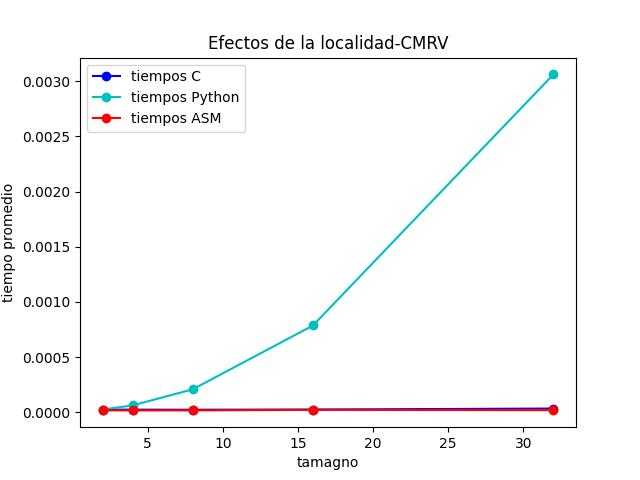

En que proporcion la implementacion en ASM es mas rapida que en Python y ASM

In [ ]:
#GRAFICO DE N VS SPEEDUP PARA CMRV
plt.figure(figsize=(10,5))
 
plt.plot(ns, tcmrv_c/tcmrv_asm, 'g-o', label='C-ASM')
plt.plot(ns, tcmrv_python/tcmrv_asm, 'r-o', label='Python-ASM')

plt.title('speedup por tamagno-CMRV')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.legend()
plt.show()
#En AWS:
#plt.savefig('CMRV_speedup.jpg')

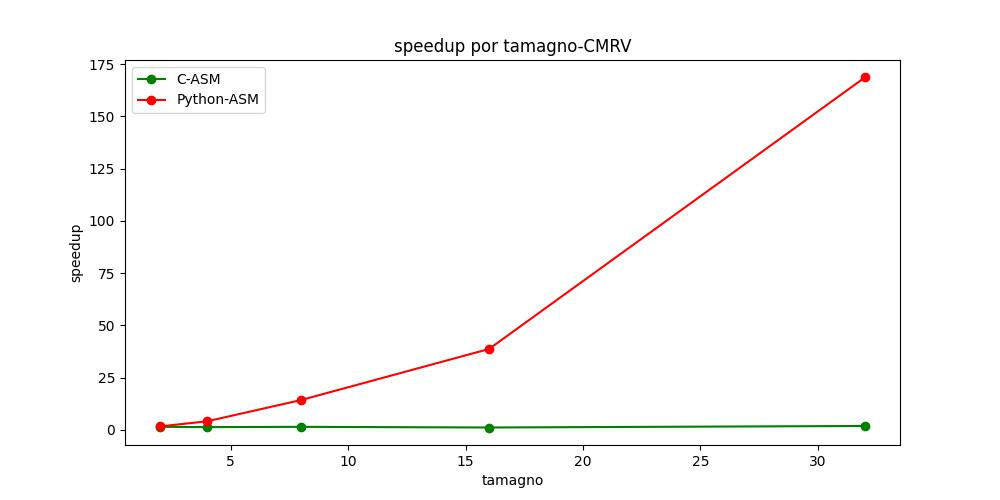

CASO 2: CMCV

In [42]:
#ns= [ 256, 512, 1024, 2048, 4096]
#Uso valores de N pequeños ya que con los casos solicitados el colab demora demasiado en ejecutar, esto me paso incluso disminuyendo el numero de iteraciones a 5
ns = [2,4,8,16,32]
veces = 10
tcmcv_c = np.zeros((len(ns),1),dtype=np.float32)
tcmcv_python = np.zeros((len(ns),1),dtype=np.float32)
tcmcv_asm = np.zeros((len(ns),1),dtype=np.float32)


for i, n in enumerate(ns):
    tcmcvi_c = []
    tcmcvi_python = []
    tcmcvi_asm = []
    for j in range(veces):
        # datos
        A = np.random.rand(n,n)
        x = np.random.rand(n,1)  
        # entradas RM
        Arm = A.flatten()
        # entradas CM
        Acm = np.transpose(A).flatten()
        # referencia
        bref = np.dot(A,x)
        # salidas
        bCMCV = np.zeros_like(bref)
        
        # tiempo Python
        t = time.time()
        matvecCMCV_python(Acm,x,bCMCV,n)
        tcmcvi_python.append(time.time() - t)
        
        # tiempo C
        t = time.time()
        matvecCMCV_c(Acm,x,bCMCV,n)
        tcmcvi_c.append(time.time() - t)
        
        # tiempo ASM
        t = time.time()
        matvecCMCV_asm(Acm,x,bCMCV,n)
        tcmcvi_asm.append(time.time() - t)

    tcmcv_python[i]=(mean(filtro_mediana(tcmcvi_python,9)))
    tcmcv_c[i]=(mean(filtro_mediana(tcmcvi_c,9)))
    tcmcv_asm[i]=(mean(filtro_mediana(tcmcvi_asm,9)))

Aca obtenemos las graficas de N vs tiempo tanto para Python, C y ensamblador

In [ ]:
#GRAFICO DE N VS TIEMPO PARA CMCV
plt.plot(ns, tcmcv_c, 'b-o', label='tiempos C')
plt.plot(ns, tcmcv_python, 'c-o', label='tiempos Python')
plt.plot(ns, tcmcv_asm, 'r-o', label='tiempos ASM')
plt.title('Efectos de la localidad-CMCV')
plt.xlabel('tamagno')
plt.ylabel('tiempo promedio')
plt.legend()
plt.show()
#En AWS:
#plt.savefig('CMCV_tiempos.jpg')

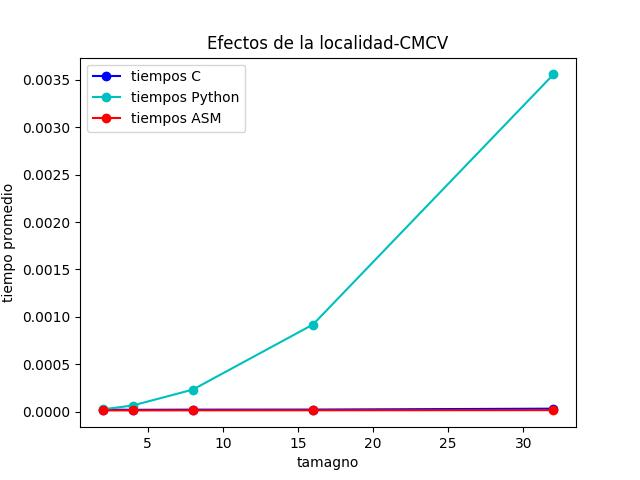

En que proporcion la implementacion en ASM es mas rapida que en Python y ASM

In [ ]:
#GRAFICO DE N VS SPEEDUP PARA CMCV
plt.figure(figsize=(10,5))
plt.plot(ns, tcmcv_c/tcmcv_asm, 'g-o', label='C-ASM')
plt.plot(ns, tcmcv_python/tcmcv_asm, 'r-o', label='Python-ASM')
plt.title('speedup por tamagno-CMCV')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.legend()
plt.show()
#En AWS:
#plt.savefig('CMCV_speedup.jpg')

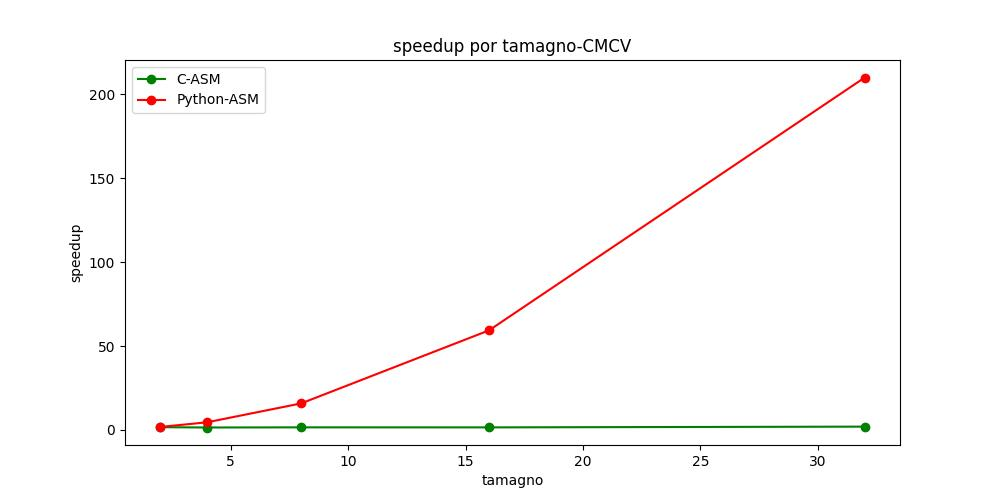

In [ ]:
! rm *.o
! rm *.so
! rm *.c